In [17]:
import numpy as np
import jax.numpy as jnp
import cvxpy as cp
import matplotlib.pyplot as plt

# Problem 3 (Linear Quadratic Regulator)

In class, we looked at the (discrete-time) non-time-varying Linear Quadratic Regular problem. Briefly, the goal is to find a sequence of control inputs $\mathbf{u}=(u_0, u_1,...,u_{N-1})$, for a time horizon of $N$ time steps, that minimizes the (quadratic) cost

$$
J(\mathbf{x}, \mathbf{u}) = \left[\sum_{k=0}^{N-1} \underbrace{
x_k^TQx_k + u_k^TRu_k}_{\text{Running cost}}\right] + \underbrace{x_N^TQ_Nx_N}_{\text{Terminal cost}}
$$

where $Q = Q^T \geq 0, k=0,...,T$, $R=R^T >0$, and subject to linear dynamics $x_{k+1} = Ax_k + B u_k$. Noting that there are no constraints on states and controls, aside from the fact that the system must start from the current state $x_0=x_\mathrm{curr}$ and obey the linear dynamics.
If we assume the value function took the form of $V(x,k) = x^TP_kx$, then we can compute the value for any state at any time step $k$ using the following recursion update rule

$$
P_{k} = Q + A^TP_{k+1}A - A^TP_{k+1}B(R+B^TP_{k+1}B)^{-1}B^TP_{k+1}A, \qquad \text{for}\; k=N-1,...,0,
$$

and the corresponding optimal gain $K_k$ where $u_k^\star = K_kx_k$ is given by

\begin{equation}
    K_k = -(R+B^TP_{k+1}B)^{-1}B^TP_{k+1}A, \qquad \text{for}\; k=0,...,N-1
\end{equation}


## (a) LQR with cross term

Consider a slightly different case where the running cost has a cross term $2x_k^TS_ku_k$. That is,

$$
\tilde{J}(\mathbf{x}, \mathbf{u}) = \left[\sum_{k=0}^{N-1}
        x_k^TQx_k + u_k^TRu_k + \underbrace{2x_k^TSu_k}_{\text{Cross term}}\right] + x_N^TQ_Nx_N,
$$

where $S \in \mathbb{R}^{n\times m}, \begin{bmatrix} Q & S \\ S^T & R\end{bmatrix}  \geq 0$ for $k=0,...,N-1$.
What is the corresponding update equation for $P_{k}$ and gain $K_k$ with the cross term present? We are still considering a time-invariant case (i.e., $A, B, Q, R, S$ are constants that do not change over time).



The derivation below is given for a time-varying system. But the only difference from the time-invariant case is that the terms $A_k, B_k, R_k, Q_k, S_k$ have been used instead of $A,B,R,Q,S$.

$ V^*(x_k,k)=min_u \hspace{2mm} x_k^T Q_k x_k + u_k^T R_k u_k +2 x_k^T S_k u_k + V^*(A_k x_k + B_k u_k, k+1) $

But the value function corresponding to the optimal control policy at at time k+1 takes the form: $x_{k+1}^T P_{k+1} x_{k+1}$. This leads to:

$ V^*(x_k,k)=min_u \hspace{2mm} x_k^T Q_k x_k + u_k^T R_k u_k +2 x_k^T S_k u_k + (A_k x_k + B u_k)^T P_{k+1} (A_k x_k + B_k u_k) $

Expanding and manipulating:

$V^*(x_k,k)= min_u \hspace{2mm} x_k^T Q_k x_k + u_k^T (R_k + B_k^T P_{k+1} B_k) u_k  + u_k^T B_k^T P_{k+1} A_k x_k + x_k^T A_k^T P_{k+1} B_k u_k + 2 x_k^T S_k $


But since each term is a scalar, we can say that the transpose of every term equals itself. We can use this fact to rewrite the last two terms which leads to:

$ V^*(x_k,k)= min_u \hspace{2mm} x_k^T Q_k x_k + u_k^T (R_k + B_k^T P_{k+1} B_k) u_k  + u_k^T (2 S_k^T + 2 B_k^T P_{k+1} A_k )x_k $

Now, let us find the optimal control policy of the form $u^*_k=-K_k x_k$ by minimizing over u. In other words, let us set the derivative of the right-hand side (d/du) equal to 0:

$ u^*_k(2R_k + 2 B_k^T P_{k+1} B_k)+(2 S_k^T+2 B_k^T P_{k+1} A_k) x_k=0 $

Hence:

$ u^*_k=-(R_k + B_k^T P_{k+1} B_k)^{-1} (S_k^T+B_k^T P_{k+1} A_k) x_k $
where: $K_k= (R_k + B_k^T P_{k+1} B_k)^{-1} (S_k^T+B_k^T P_{k+1} A_k)$ for $k=N-1, ...., 0$


Having obtained the optimal control policy, let us substitute the optimal control policy at time k $u^*_k=-K_k x_k$ into our expression for $V^*(x_k,k)$:

$ V^*(x_k,k)=x_k^T P_k x_k=x_k^T [Q_k + K_k^T R_k K_k - 2 S_k K_k +  (A_k^T-K_k^T B_k^T)P_{k+1}(A_k - B_k K_k)]x_k $

Dropping $x_k^T...x_k$ on both sides of the equality and rearranging leads to:

$ (Q_k+A_k^T P_{k+1} A_k)+K_k^T (R_k + B_k^T P_{k+1} B_k) K_k -2 K_k^T B_k^T P_{k+1} A_k -2 S_k K_k $

Now, we substitute in the expression for $K_k$:

 $P_k = (Q_k + A_k^T P_{k+1} A_k) + (S_k^T + B_k^T P_{k+1} A_k) ^T ((R_k+B_k^T P_{k+1} B_k)^{-1})^T (S_k^T+ B_k^T P_{k+1} A_k)
 -2 (S_k^T + B_k^T P_{k+1} A_k)^T ((R_k+B_k^T P_{k+1} B_k)^{-1})^T B_k^T P_{k+1} A_k -2 S_k (R_k+B_k^T P_{k+1} B_k)^{-1}(S_k^T + B_k^T P_{k+1} A_k)$

 Now, we note that $((R_k+B_k^T P_{k+1} B_k)^{-1})^T=(R_k+B_k^T P_{k+1} B_k)^{-1}$ since all the terms in it are symmetric. Once again, we can take the transpose of the final term since it is a scalar which leads to the final term being: $ -2 (S_k^T + B_k^T P_{k+1} A_k)^T (R_k+B_k^T P_{k+1} B_k)^{-1} S_k^T$. Now, all the terms may simply be added yielding the recursion formula for P:

 $ P_k = (Q_k + A_k^T P_{k+1} A_k) -(S_k^T + B_k^T P_{k+1} A_k) ^T (R_k+B_k^T P_{k+1} B_k)^{-1} (S_k^T+ B_k^T P_{k+1} A_k) $

 Simplfying the first factor in the second term results in the recusion formula:

  $ P_k = Q_k + A_k^T P_{k+1} A_k -(S_k + A_k^T P_{k+1} B_k) (R_k+B_k^T P_{k+1} B_k)^{-1} (S_k^T+ B_k^T P_{k+1} A_k) $ for $ k = N-1,....,0$

 The recursion is started at by setting $P_N$ (where $N=k+1$) equal to $Q_N$.


## (b) Time-varying LQR

For standard LQR (i.e., without the cross term introduced in the previos part), what is the corresponding update equation for $P_{k}$ and gain $K_k$ if the dynamics are time-varying? That is, when $x_{k+1} = A_kx_k + B_ku_k$, where $A_k$ and $B_k$ are dependent on $k$.



Simply set $S_k =0$ from the previous derivation as there is no cross term:

$ u^*_k=-(R_k + B_k^T P_{k+1} B_k)^{-1} (B_k^T P_{k+1} A_k) x_k $
where: $K_k= (R_k + B_k^T P_{k+1} B_k)^{-1} (B_k^T P_{k+1} A_k) $ for $k=N-1,...,0$

And $P_k$ is given by:

 $ P_k = (Q_k + A_k^T P_{k+1} A_k) -(A_k^T P_{k+1} B_k )  (R_k+B_k^T P_{k+1} B_k)^{-1} (B_k^T P_{k+1} A_k) $ for $k=N-1, ... , 0$



 Once again, the recusion for $P_k$ is started by setting $P_N = Q_N$.

## (c) Dynamic programming vs. convex optimization

The dynamic programming method we discussed in class is a method of analytically solving a minimization problem in closed form, minimizing the cost $J(\mathbf{x}, \mathbf{u})$ subject to the constraint $x_{k+1} = Ax_k + Bu_k$. But since the cost function and constraint set are both convex, we can also use convex optimization methods to solve the same problem numerically.

Consider an LQR problem with

$$
A = \begin{bmatrix}
1 & 0 & 0.1 & 0 \\
0 & 1 & 0 & 0.1 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix},\quad B = \begin{bmatrix}
0.005 & 0 \\
0 & 0.005 \\
0.1 & 0 \\
0 & 0.1
\end{bmatrix},
$$

and $R = I, Q = 3I, Q_N = 10I$, and $N = 10$. The initial state is $x_{init} = [1, 2, -0.25, 0.5]$. These data are given in the cell immediately below.

In [18]:
# Problem data (given)

# These are the result of discretizing 2D double integrator dynamics with zero-order hold and dt = 0.1
A = np.array([[1, 0, 0.1, 0],
              [0, 1, 0, 0.1],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

B = np.array([[0.005, 0],
              [0, 0.005],
              [0.1, 0],
              [0, 0.1]])

# LQR cost matrices
Q = 3 * np.eye(4)
R = np.eye(2)
Q_N = 10 * np.eye(4)

# Time horizon
N = 10

# Initial state
x_init = np.array([1, 2, -0.25, 0.5])



### (c)(i) Solution via LQR
In the following cell, find the finite-horizon LQR controller for each time step by the iterative LQR process, and simulate the trajectory over the given time horizon with the given initial state. The provided plotting code at the end of the cell will plot the resulting state trajectory and control history.

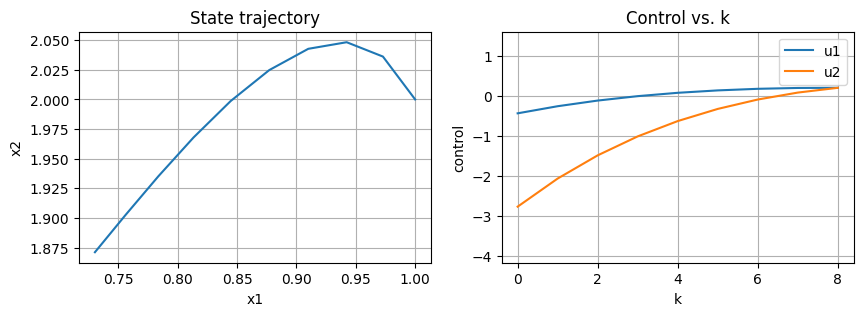

In [19]:
# LQR implementation goes in this cell

P_matrices = []
K_matrices = []

x_trajectory_lqr = np.zeros((N,4))
u_history_lqr = np.zeros((N-1, 2))


###### FILL CODE HERE ######

# as a result of your code, the P_matrices list defined above should contain the ten P matrices in increasing order of time,
# and the K_matrices list defined above should contain the nine K matrices in increasing order of time.
#
# x_trajectory_lqr should contain the complete state trajectory (with the k-th row of x_trajectory_lqr containing
# the state at time k), and likewise u_history_lqr should contain the complete control history (with the k-th row
# of u_history_lqr containing the control at time k).



#Below, we recursively calculate P and K matrices for k=N-1 to 0 (offline part of LQR)
P_matrices.append(Q_N)
for i in range(N-1):
  K_k=np.linalg.inv(R+B.T@P_matrices[0]@B)@(B.T@P_matrices[0]@A)
  K_matrices.insert(0, K_k)

  P_k=Q+A.T@P_matrices[0]@A-(A.T@P_matrices[0]@B)@K_k
  P_matrices.insert(0,P_k)

#Below, we apply the control (u=-K*x) to calculate the trajectory (online part of LQR)
x_trajectory_lqr[0]=x_init
for i in range(N-1):
  xcurrent=x_trajectory_lqr[i]
  control_k=-1*K_matrices[i]@xcurrent
  u_history_lqr[i]=control_k

  x_next=A@xcurrent+B@control_k
  x_trajectory_lqr[i+1]=x_next

##########################################

# Provided plotting code
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(x_trajectory_lqr[:,0], x_trajectory_lqr[:,1])
plt.title("State trajectory")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(N-1), u_history_lqr[:,0], label="u1")
plt.plot(range(N-1), u_history_lqr[:,1], label="u2")
plt.legend()
plt.title("Control vs. k")
plt.xlabel("k")
plt.ylabel("control")
plt.axis("equal")
plt.grid()


### (c)(ii) Solution via convex optimization
In the following cell, directly find a state trajectory and control history that solves the same LQR optimization problem using cvx. The provided plotting code at the end of the cell will plot the resulting state trajectory and control history.

Hint: you may find the cvxpy function `quad_form` (documented [here](https://www.cvxpy.org/api_reference/cvxpy.atoms.other_atoms.html#quad-form)) useful. Since $Q$ and $R$ are both positive (semi)definite, the quadratic forms $x^TQx$ and $u^TRu$ are convex, but because of subtleties of [the way cvxpy works](https://www.cvxpy.org/tutorial/dcp/index.html), cvxpy does not immediately recognize those expressions as convex in general. `quad_form` provides additional information to cvxpy that allows it to determine the convexity of those expressions.

In [20]:
import cvxpy as cp

status: optimal
optimal value 191.13862886952796
optimal var [[ 1.          2.         -0.25        0.5       ]
 [ 0.97285806  2.03620079 -0.29283878  0.22401571]
 [ 0.94232013  2.04831536 -0.31791985  0.01827574]
 [ 0.90998072  2.0427532  -0.32886841 -0.12951889]
 [ 0.87709773  2.02478032 -0.32879137 -0.22993862]
 [ 0.84463981  1.99867853 -0.32036703 -0.29209733]
 [ 0.81332519  1.96787891 -0.30592527 -0.32389498]
 [ 0.78365294  1.93507239 -0.28751979 -0.33223534]
 [ 0.75592726  1.90229948 -0.26699388 -0.32322304]
 [ 0.73027551  1.87102114 -0.24604114 -0.30234377]] [[-4.28387805e-01 -2.75984292e+00]
 [-2.50810704e-01 -2.05739973e+00]
 [-1.09485598e-01 -1.47794628e+00]
 [ 7.70427869e-04 -1.00419725e+00]
 [ 8.42433899e-02 -6.21587138e-01]
 [ 1.44417591e-01 -3.17976523e-01]
 [ 1.84054844e-01 -8.34035645e-02]
 [ 2.05259071e-01  9.01230170e-02]
 [ 2.09527367e-01  2.08792711e-01]]


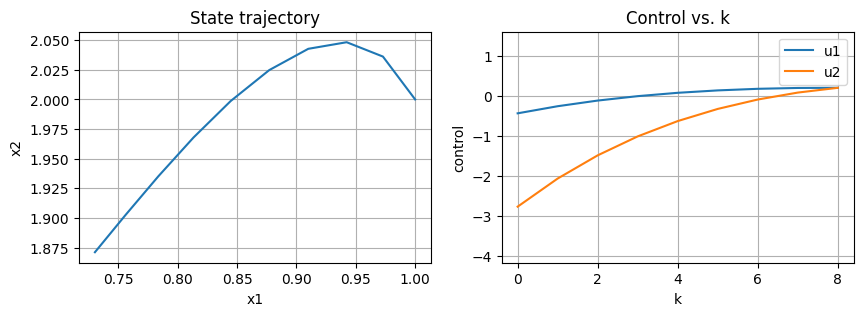

In [21]:
# CVX implementation goes in this cell

x_trajectory_cvx = np.zeros((N,4))
u_history_cvx = np.zeros((N-1, 2))

###### FILL CODE HERE ######

# As a result of your code, x_trajectory_cvx should contain the complete state trajectory (with the k-th row of x_trajectory_cvx containing
# the state at time k), and likewise u_history_cvx should contain the complete control history (with the k-th row of u_history_cvx
# containing the control at time k).

#Form variables to optimize over (decision variabes)
x_trajectory_cvx = cp.Variable((N,4))
u_history_cvx= cp.Variable((N-1, 2))

#Formulate objective (the cost to minimize)

cost=0
for k in range(N-1):   # accumulate cost for k=0,...N,-1
  #add state cost x^T*Q*x
  xk=x_trajectory_cvx[k,:]
  cost += cp.atoms.quad_form(xk, Q, assume_PSD=True)

  # add control cost u^T*R*u
  uk=u_history_cvx[k,:]
  cost += cp.atoms.quad_form(uk, R, assume_PSD=True)

#add terminal cost
xfinal=x_trajectory_cvx[N-1,:]
cost += cp.atoms.quad_form(xfinal, Q_N, assume_PSD=True)

obj = cp.Minimize(cost)

#Formulate constraints in a list of constraints:
constraints = [x_trajectory_cvx[0,:] == x_init] #The initial state constraint (at k=0)

for k in range(N-1): # the dynamics constraints for k=0, .... N-1
  constraints.append(x_trajectory_cvx[k+1,:]==A@x_trajectory_cvx[k,:].T+B@u_history_cvx[k,:].T)

prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.

print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x_trajectory_cvx.value, u_history_cvx.value)

#Extract the value of the cvxpy parameters
x_trajectory_cvx=x_trajectory_cvx.value
u_history_cvx=u_history_cvx.value


######################################################

# Provided plotting code
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(x_trajectory_cvx[:,0], x_trajectory_cvx[:,1])
plt.title("State trajectory")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(N-1), u_history_cvx[:,0], label="u1")
plt.plot(range(N-1), u_history_cvx[:,1], label="u2")
plt.legend()
plt.title("Control vs. k")
plt.xlabel("k")
plt.ylabel("control")
plt.axis("equal")
plt.grid()

## (d) Open-loop vs. closed-loop

You should have gotten the same results from LQR and cvxpy in the previous part. LQR is a method of designing a _closed-loop controller_ that minimizes $J(\mathbf{x}, \mathbf{u})$. In contrast, the trajectory optimization with cvxpy is an _open-loop_ method, which designs an entire trajectory in advance and provides a numerical sequence of control inputs to achieve that trajectory; notably, the sequence of control inputs is given as a fixed, independent output of the optimizer, without reference to whatever the state may be at any point along the trajectory.

When and why might we prefer one technique over the other? Discuss.

# Answer:

LQR works partially online (calculates K matrices offline, but the control input u given by u=-K*x_current online) whereas trajectory optimization works completely offline.When the cost function defining LQR and trajectory optimization is the same, starting from the same inital conditions, under no disturbances, the sequence of control inputs applied by LQR and offline trajectory optimization are identical.

However, LQR is more robust, meaning that it can deal with external disturbances and mismatch between the real initial condition and planned initial condition. This is because LQR is a closed loop method.
This means that the control input aplied (u=-K x_current) depends on the current state of the robot, which is influenced by disturbances and offsets in initial conditions. In a controller based on offline trajectory optimization, the control sequence applied to the robot is predetermined and will not change regardless of disturbances and deviation from planned path.

Though LQR is more robust from a disturbance point of view, with the LQR method, it is not possible to enforce constraints such as obstacle avoidance. With a trajectory optimization based controller, obstacles, waypoints, limits on states and control inputs can be explicitly set as constraints. Hence, the resulting set of control inputs abides by these constraints.

P.S. Run the cell below to check that the solutions found by both methods match.

In [22]:


print("States match:", np.allclose(x_trajectory_cvx, x_trajectory_lqr))
print("Controls match:", np.allclose(u_history_cvx, u_history_lqr))

States match: True
Controls match: True
